![logo.png](https://github.com/interviewquery/takehomes/blob/amazon_1/amazon_1/logo.png?raw=1)

# Overview

You are selling certain items at your store. Every once in a while you may experience shortage. In which case, you notify your customers when your inventory will be replenished. You want to know which percent of your customers are not waiting for the replenishment and buying the item elsewhere - lost sales due to shortage. (Note that some do wait for your replenishment which is expressed as a higher demand at the day of replenishment).

![](https://cdn.mathpix.com/cropped/2022_09_14_28e45c346ad5b3be11fag-1.jpg?height=681&width=1632&top_left_y=527&top_left_x=252)

**How would you find that out?**

Simplifying assumptions:

1. The demand has no trend and no seasonality.

2. We may assume demand to follow the function $d_{t}=d_{t-1}+\varepsilon_{t}$, where $\varepsilon_{t}$ is the noise such that $\varepsilon_{t} \sim \mathcal{N}\left(0, \sigma^{2}\right)$. That is, the noise is symmetric and unbiased.

3. Customers experiencing shortage that decide to come back, would only come back on the day of replenishment.

4. Replenishment occurs in the beginning of days only.

5. Each customer buys no more than 1 item

In [88]:
!git clone --branch amazon_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/amazon_1
!ls
!if [[ $(ls *.zip) ]]; then unzip *.zip; fi

Cloning into 'takehomes'...
remote: Enumerating objects: 1963, done.
remote: Counting objects: 100% (1963/1963), done.
remote: Compressing objects: 100% (1220/1220), done.
remote: Total 1963 (delta 752), reused 1927 (delta 726), pack-reused 0
Receiving objects: 100% (1963/1963), 297.43 MiB | 18.04 MiB/s, done.
Resolving deltas: 100% (752/752), done.
/content/takehomes/amazon_1/takehomes/amazon_1
data.csv  logo.png  takehomefile.ipynb
ls: cannot access '*.zip': No such file or directory


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [90]:
data = pd.read_csv('data.csv')
data.head(10)


,date,inventory,sales
0,7/1/20,189,31
1,7/2/20,159,30
2,7/3/20,127,32
3,7/4/20,101,26
4,7/5/20,74,27
5,7/6/20,28,46
6,7/7/20,0,28
7,7/8/20,0,0
8,7/9/20,963,37
9,7/10/20,942,21


In [91]:
data.shape

(374, 3)

In [92]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       374 non-null    object
 1   inventory  374 non-null    int64 
 2   sales      374 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.9+ KB


In [93]:
min(data.date), max(data.date)

('1/1/21', '9/9/20')

<ipython-input-94-d7c30dd015dd>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data.date[:100], rotation=90)
<ipython-input-94-d7c30dd015dd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(data.date[:100], rotation=90)


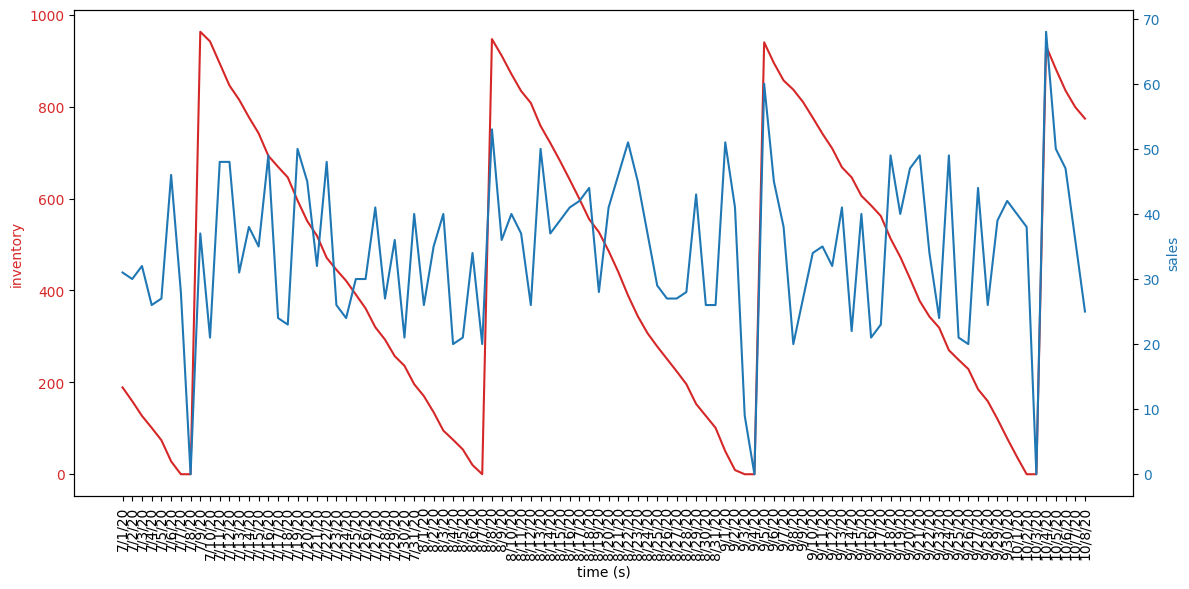

In [94]:
fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('inventory', color=color)
ax1.plot(data.date[:100], data.inventory[:100], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(data.date[:100], rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sales', color=color)  # we already handled the x-label with ax1
ax2.plot(data.date[:100], data.sales[:100], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticklabels(data.date[:100], rotation=90)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [95]:
#define shortage days
data['is_shortage_day'] = 0
data.loc[(data['inventory'] == 0), "is_shortage_day"] = 1

In [96]:
data.head(10)

,date,inventory,sales,is_shortage_day
0,7/1/20,189,31,0
1,7/2/20,159,30,0
2,7/3/20,127,32,0
3,7/4/20,101,26,0
4,7/5/20,74,27,0
5,7/6/20,28,46,0
6,7/7/20,0,28,1
7,7/8/20,0,0,1
8,7/9/20,963,37,0
9,7/10/20,942,21,0


In [97]:
# define is_replenishment_day
data['is_replenishment_day'] = 0
data.loc[((data['inventory'] - data['inventory'].shift(1)) == data['inventory']) & (data['inventory'] != 0), "is_replenishment_day"] = 1


In [98]:
data.head(10)

,date,inventory,sales,is_shortage_day,is_replenishment_day
0,7/1/20,189,31,0,0
1,7/2/20,159,30,0,0
2,7/3/20,127,32,0,0
3,7/4/20,101,26,0,0
4,7/5/20,74,27,0,0
5,7/6/20,28,46,0,0
6,7/7/20,0,28,1,0
7,7/8/20,0,0,1,0
8,7/9/20,963,37,0,1
9,7/10/20,942,21,0,0


# create demants for shortage days and replemishment days

In [99]:
# demand = d[t-1] + eps(t)
data['demand'] = data.sales.shift(1) + np.random.normal(0, np.sqrt(2), len(data))

# for shortage day demand is calculated via demand[t-1]
data.loc[(data['inventory'] == 0)&(data['sales'] == 0), 'demand'] = data.demand.shift(1)+np.random.normal(0, np.sqrt(2), len(data))

# for replenishment day demand is calculated via demand[t-1]
data.loc[data['is_replenishment_day'] == 1, 'demand'] = data.demand.shift(1)+np.random.normal(0, np.sqrt(2), len(data))

data.head(10)


,date,inventory,sales,is_shortage_day,is_replenishment_day,demand
0,7/1/20,189,31,0,0,NaN
1,7/2/20,159,30,0,0,31.475070
2,7/3/20,127,32,0,0,30.606938
3,7/4/20,101,26,0,0,32.174049
4,7/5/20,74,27,0,0,25.852186
5,7/6/20,28,46,0,0,29.160621
6,7/7/20,0,28,1,0,46.798714
7,7/8/20,0,0,1,0,44.644718
8,7/9/20,963,37,0,1,44.982299
9,7/10/20,942,21,0,0,36.726527


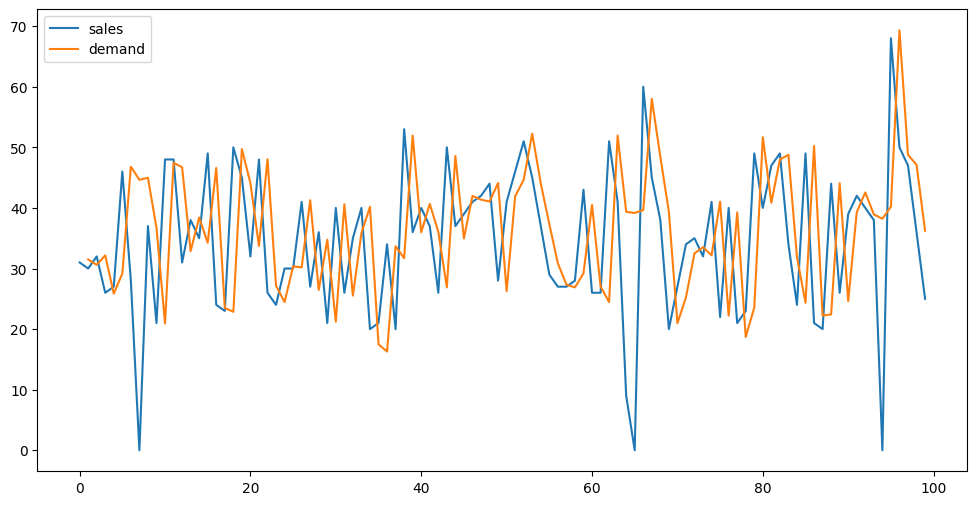

In [100]:
plt.figure(figsize=(12,6))
plt.plot(data.sales[:100])
plt.plot(data.demand[:100])
plt.legend(['sales','demand'])
plt.show()

In [101]:
# calculate the lost people for shortage and replenishment days. For replacement day it will be return people

data.loc[(data.is_shortage_day == 1)|(data.is_replenishment_day ==1),'lost'] =  data.demand - data.sales

In [102]:
special_days = data[(data.is_shortage_day == 1)|(data.is_replenishment_day ==1)]
special_days.head(10)

,date,inventory,sales,is_shortage_day,is_replenishment_day,demand,lost
6,7/7/20,0,28,1,0,46.798714,18.798714
7,7/8/20,0,0,1,0,44.644718,44.644718
8,7/9/20,963,37,0,1,44.982299,7.982299
37,8/7/20,0,20,1,0,33.682946,13.682946
38,8/8/20,947,53,0,1,31.702980,-21.297020
64,9/3/20,0,9,1,0,39.355155,30.355155
65,9/4/20,0,0,1,0,39.168692,39.168692
66,9/5/20,940,60,0,1,39.641715,-20.358285
93,10/2/20,0,38,1,0,38.927965,0.927965
94,10/3/20,0,0,1,0,38.224452,38.224452


In [106]:
wating_count= 0
losses = []
for _, day in special_days.iterrows():
  if day.is_shortage_day:
    wating_count += day.lost
  elif day.is_replenishment_day:
    # if day.lost < 0 this means that this people came back
    if day.lost < 0:
      l = (wating_count + day.lost)
      # l < 0 means that all people came back
      if l >0 and wating_count != 0:
        losses.append(l/wating_count)
      else:
        losses.append(0)
    else :
      # we lost all people that were wating
      losses.append(1)
    wating_count = 0


In [107]:
losses

[1,
 0,
 0.7071755114610769,
 0.2900278332237766,
 0,
 0.5391161110138059,
 1,
 0.38068851791981445,
 0.07765478563524608,
 0,
 0,
 0,
 0.27875666944383487]

In [108]:
print(f'Lost sales due to shortage= {np.mean(losses) * 100}%')


Lost sales due to shortage= 32.87245714382735%
